In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [2]:
import numpy as np
import pandas as pd
import re 
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer

from nltk.corpus import stopwords

# Initialize the stopwords
stoplist = stopwords.words('english')

hinglishStopList = []
with open("hinglish_stopwords.txt",'r') as reader:
    for line in reader:
        hinglishStopList.append(line.strip())



In [3]:
print ((stoplist))
print ((hinglishStopList))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [4]:
# --------------Clean Data code, creates sentences fron conll tokens, removes usernames and urls
# --------------creates cleaned_train.tsv with cleaned_conll_to_tsv func
import json
import random
import string


class ConllToken:
    """ Parent token class. """
    def __init__(self, token_type):
        self.token_type = token_type


class Sentiment(ConllToken):
    """ Sentiment token class. """
    def __init__(self, sentiment):
        super().__init__("sentiment")
        self.sentiment = sentiment
    
    @staticmethod
    def is_instance(token):
        return token.token_type == "sentiment"

    def __eq__(self, other):
        return (Sentiment.is_instance(other) and 
                other.sentiment == self.sentiment)


class EndOfSegment(ConllToken):
    """ End of Segment token class. """
    def __init__(self):
        super().__init__("end")
        
    @staticmethod
    def is_instance(token):
        return token.token_type == "end"
        
    def __eq__(self, other):
        return EndOfSegment.is_instance(other)


class BasicToken(ConllToken):
    """ Basic token class. """
    def __init__(self, value):
        super().__init__("basic")
        self.value = value

    @staticmethod
    def is_instance(token):
        return token.token_type == "basic"
    
    def __eq__(self, other):
        return (BasicToken.is_instance(other) and 
                other.value == self.value)


class URL(ConllToken):
    """ URL token class. """
    def __init__(self, value):
        super().__init__("url")
        self.value = value

    @staticmethod
    def is_instance(token):
        return token.token_type == "url"
    
    def __eq__(self, other):
        return URL.is_instance(other) and other.value == self.value


class Username(ConllToken):
    """ Username token class. """
    def __init__(self, value):
        super().__init__("username")
        self.value = value

    @staticmethod
    def is_instance(token):
        return token.token_type == "username"
    
    def __eq__(self, other):
        return Username.is_instance(other) and other.value == self.value


def tokenize_conll(lines, sentimentNotAvailable):
    """ Tokenize lines in a file. """
    for line in lines:
        # print (line)
        if line.strip() == "":
            # print ('triggered')
            yield EndOfSegment()
        else:
            fields = line.split("\t")
            if fields[0] == "meta":
                if sentimentNotAvailable:
                  yield Sentiment("none")
                else:
                  yield Sentiment(fields[2].strip())
            else:
                yield BasicToken(fields[0].strip())


def cluster_urls(tokens):
    """ 
    Generator for piecing together URLs in token streams.
    Reads from an instream, and if the instream has broken URL pieces
    (identified by finding 'http') in conll format, the generator yields 
    a complete URL.
    """
    url_builder = ""
    for token in tokens:
        if BasicToken.is_instance(token):
            if url_builder == "" and not token.value.startswith("http"):
                yield token
            elif token.value.startswith("http"):                
                url_builder = token.value
            else:
                url_builder += token.value
        else:
            if url_builder != "":
                yield URL(url_builder)
                url_builder = ""
            yield token
    if url_builder != "":
        yield URL(url_builder) 


def cluster_usernames(tokens):
    """ 
    Generator for piecing together Twitter usernames in token streams.
    Reads from an instream, and if the instream has broken username pieces
    (identified by an '@' symbol) in conll format, the generator 
    yields a complete username.
    """
    builder = ""
    for token in tokens:
        if BasicToken.is_instance(token) and builder == "":
            if token.value == "@":
                builder = token.value
            else:
                yield token
        elif BasicToken.is_instance(token):            
            if builder == "@" or builder[-1] == "_":
                builder += token.value
            elif token.value == "_":
                builder += token.value
            else:
                yield Username(builder)
                builder = ""
                if token.value == "@":
                    builder = token.value
                else:
                    yield token
        else:
            if builder != "":
                yield Username(builder)
                builder = ""
            yield token
    if builder != "":
        yield Username(builder) 

def conll_to_tsv(conll_file, tsv_file, sentimentNotAvailable = False):
    """ Convert conll format to TSV. """
    testLabels=[]
    if sentimentNotAvailable:
      testLabels = read_test_labels("test_labels_hinglish.txt")

    with open(conll_file) as reader:
        with open(tsv_file, 'w') as writer:

            table = str.maketrans('', '', string.punctuation)

            tokens = tokenize_conll([line for line in reader],sentimentNotAvailable)
            tokens = cluster_urls(tokens)
            tokens = cluster_usernames(tokens)
            segment_tokens = []
            sentiment = -1
            for tok in tokens:
                if Sentiment.is_instance(tok):
                    if tok.sentiment == "negative":
                        sentiment = 0
                    elif tok.sentiment == "neutral":
                        sentiment = 1
                    elif tok.sentiment == "positive":
                        sentiment = 2
                    elif tok.sentiment == "none":
                        sentiment = 3
                elif EndOfSegment.is_instance(tok):                    
                    next_segment = ' '.join(segment_tokens)
                    next_segment += '\t' + str(sentiment)
                    if sentiment >= 0:
                        writer.write(next_segment + '\n')
                    sentiment = -1
                    segment_tokens = []
                elif BasicToken.is_instance(tok):
                    segment_tokens.append(tok.value)
            if sentiment >= 0:
                next_segment = ' '.join(segment_tokens)
                next_segment += '\t' + str(sentiment)
                writer.write(next_segment + '\n')
    if sentimentNotAvailable:
      write_test_labels(tsv_file, 'newDev.tsv',testLabels)

def read_test_labels(input_file):
  '''for reading from the hindi_test_unlablled file'''
  testLabels = []
  with open(input_file, 'r') as reader:
    for line in reader:
      line = line.split(',')
      if line[0] != "Uid":
        testUids.append(line[0])
        line = line[1]
        testLabels.append(line)
    # testLabels = testLabels[1:]
    for i in range(len(testLabels)):
      if testLabels[i].strip() == "negative":
        testLabels[i] = 0
      elif testLabels[i].strip() == "neutral":
        testLabels[i] = 1
      elif testLabels[i].strip() == "positive":
        testLabels[i] = 2 
  return testLabels

def write_test_labels(read_file, write_file,testLabels):
  '''for writing to dev file in bag of words folder'''
  with open(read_file,'r') as reader:
    with open(write_file, 'w') as writer:
      i = 0
      for line in reader:
        tweet = line[:-3]
        writer.write(str(tweet) + "\t" + str(testLabels[i]) + "\n")
        i += 1


def testify(input_file, output_file):
    """ Formats given trial data into test data. """
    with open(input_file, 'r') as reader:
        with open(output_file, 'w') as writer:
            writer.write("index\tsentence\n")
            index = 0
            for line in reader:
                line = line.split("\t")[0]
                if line != "sentence":
                    writer.write(f"{index}\t{line}\n")
                    index += 1


# if __name__ == "__main__":
  # # drive/MyDrive/data/train_14k_split_conll.txt
  #   conll_to_tsv('drive/MyDrive/data/train_14k_split_conll.txt','drive/MyDrive/data/bag-of-words/train.tsv',False)
  #   # testify('drive/MyDrive/data/Hindi_test_unalbelled_conll_updated.txt', 'drive/MyDrive/data/bag-of-words/dev.tsv')
  #   conll_to_tsv('drive/MyDrive/data/Hindi_test_unalbelled_conll_updated.txt','drive/MyDrive/data/bag-of-words/dev.tsv',True)

In [5]:
""" Script containing functions and neural networks for the bag-of-words and count-words models. """

import torch
import numpy as np
import sklearn.metrics as metrics

def simple_accuracy(preds, labelss):
  
    # return np.equal(preds, labels).mean()
    # f1_score(labels, preds, average = 'weighted')
    # return metrics.confusion_matrix(y_true, y_pred), metrics.classification_report(y_true, y_pred, digits=3)
    return np.equal(preds, labelss).mean(),metrics.f1_score(labelss,preds, average = 'weighted')

def get_labels(filename):
    """ Returns a list of labels for sentences in a given file. """
    with open(filename,'r') as reader:
        labels = []
        for line in reader:
            line_split = line.split('\t')
            if line_split[1].strip() != 'label' and len(line_split)>1:
                labels.append(int(line_split[1]))
            elif len(line_split) < 1:
                labels.append(0)
        return labels

def create_vocab(frequencies, K):
    """ Creates a list of words as vocabulary by selecting words with a frequency > K. """
    if '…' in frequencies:
        del frequencies['…']

    for key in list(frequencies):
        if frequencies[key] < K:
            del frequencies[key]
    return list(frequencies)


""" Models for setting baseline. """ 

def two_layer_net(input_size, H):
    """
    A two-layer feedforward neural network with 'input_size' input features, H hidden
    features, and a softmax response value.
    
    """
    net = torch.nn.Sequential()
    net.add_module("dense1", torch.nn.Linear(in_features = input_size, 
                                   out_features = H))
    net.add_module("relu1", torch.nn.ReLU())
    net.add_module("dense2", torch.nn.Linear(in_features = H, 
                                   out_features = 3))
    net.add_module("softmax", torch.nn.Softmax(dim=1))

    return net.cuda()

def three_layer_net(input_size, H1, H2):
    """
    A three-layer feedforward neural network with 'input_size' input features, H1, H2 hidden
    features, and a softmax response value.
    
    """
    net = torch.nn.Sequential()
    net.add_module("dense1", torch.nn.Linear(in_features = input_size, 
                                   out_features = H1))
    net.add_module("relu1", torch.nn.ReLU())
    net.add_module("dense2", torch.nn.Linear(in_features = H1,
                                   out_features = H2))
    net.add_module("relu2", torch.nn.ReLU())
    net.add_module("dense3", torch.nn.Linear(in_features = H2,
                                   out_features = 3))
    net.add_module("softmax", torch.nn.Softmax(dim=1))

    return net


def four_layer_net(input_size, H1, H2, H3):
    """
    A four-layer feedforward neural network with 'input_size' input features, H1, H2, H3 hidden
    features, and a softmax response value.
    
    """
    net = torch.nn.Sequential()
    net.add_module("dense1", torch.nn.Linear(in_features = input_size, 
                                   out_features = H1))
    net.add_module("relu1", torch.nn.ReLU())
    net.add_module("dense2", torch.nn.Linear(in_features = H1,
                                   out_features = H2))
    net.add_module("relu2", torch.nn.ReLU())
    net.add_module("dense3", torch.nn.Linear(in_features = H2,
                                   out_features = H3))
    net.add_module("relu3", torch.nn.ReLU())
    net.add_module("dense4", torch.nn.Linear(in_features = H3,
                                   out_features = 3))
    net.add_module("softmax", torch.nn.Softmax(dim=1))

    return net



def get_bigram_frequencies(filename):
    """ Returns a dictionary of the frequencies of all words and all bigrams in a given file. """
    with open(filename,'r') as reader:
        frequencies = {}
        for line in reader:
            words_in_line = line.split('\t')[0].strip().split(' ')
            for word in words_in_line:
                if word in frequencies:
                    frequencies[word] += 1
                else:
                    frequencies[word] = 1
            # Make BiGrams
            for i in range(1,len(words_in_line),2):
                if i != len(words_in_line) - 1:
                    bigram1 = words_in_line[i-1] + " " + words_in_line[i]
                    if bigram1 in frequencies:
                        frequencies[bigram1] += 1
                    else:
                        frequencies[bigram1] = 1
                    bigram2 = words_in_line[i] + " " +  words_in_line[i+1]
                    if bigram2 in frequencies:
                        frequencies[bigram2] += 1
                    else:
                        frequencies[bigram2] = 1
        return frequencies


def create_bigram_vectors(filename, vocab):
    """ Creates 1-hot vectors from a given vocabulary set of words. """
    tweet_vectors = []
    hidden_length = len(vocab)
    with open(filename,'r') as reader:
        for line in reader:
            tweet_tensor = torch.zeros(hidden_length)
            line = line.split('\t')[0].strip()
            if line != 'sentence':
                for i in range(0,hidden_length):
                    if vocab[i] in line:
                        tweet_tensor[i] = 1
                tweet_vectors.append(tweet_tensor)
        return tweet_vectors



In [6]:
""" The script to train and run the Bag-of-Words BiGrams extension on a trainset and devset. """

import torch
import numpy as np
import copy
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

##########################################################################################
# Important Constants

FREQ_THRESHOLD = 15
BATCH_SIZE = 6
VOCAB = []
INPUT_SIZE = 0
H1 = 300
H2 = 180
H3 = 75
NUM_EPOCHS = 40
LEMMATIZE = False
STEM = False
CLEANFILE = True

##########################################################################################

def remove_stopwords_punctutation(row):
    tweet = str(row['sentences'])
    tokens = word_tokenize(tweet)
    # taken only words (not punctuation)
    # and w not in hinglishStopList
    # and w not in stoplist
    token_words = [w for w in tokens if w.isalpha()and w not in stoplist]
    return ' '.join(token_words)

def clean_file(input_filename,output_filename , lemmatize, stem):
  # will always remove punctuation and emojis, stemming and lemmatizing depends on parameters
  testDf = pd.read_csv(input_filename, sep="\t", header=None, names = ['sentences','label'])
  tokenizer = RegexpTokenizer(r'\w+')
  # reduce to lower case
  testDf['sentences'] = testDf['sentences'].str.lower()
  # remove some punctuation and stopwords
  testDf['sentences'] = testDf.apply(remove_stopwords_punctutation,axis=1)

  if lemmatize:
    lemmatizer = WordNetLemmatizer() 
    testDf['cleaned'] = testDf['sentences'].apply(lambda x: str(' '.join(tokenizer.tokenize(str(x))))).apply(lambda x: lemmatizer.lemmatize(x))
  elif stem:
    ps = PorterStemmer() 
    testDf['cleaned'] = testDf['sentences'].apply(lambda x: str(' '.join(tokenizer.tokenize(str(x))))).apply(lambda x: ps.stem(x))
  else:
    testDf['cleaned'] = testDf['sentences'].apply(lambda x: str(' '.join(tokenizer.tokenize(str(x)))))
  # display(testDf)
  testDf.to_csv(output_filename,columns = ['cleaned','label'],sep = '\t',header = False, index = False)

def make_train_vectors(input_filename):

    # Create vectors
    frequencies = get_bigram_frequencies(input_filename)
    global VOCAB, INPUT_SIZE
    VOCAB = create_vocab(frequencies, FREQ_THRESHOLD)
    vecs = create_bigram_vectors(input_filename, VOCAB)

    # Set value for input size
    INPUT_SIZE = len(VOCAB)

    # Get labels from file
    labels = get_labels(input_filename)

    assert(len(labels)==len(vecs))

    return vecs, labels

def make_test_vectors(input_filename):

    # Create vectors
    vecs = create_bigram_vectors(input_filename, VOCAB)

    # Get labels from file
    labels = get_labels(input_filename)#read_test_labels("drive/MyDrive/data/test_labels_hinglish.txt")#get_labels(input_filename)

    assert(len(labels)==len(vecs))

    return vecs, labels

class BiGramsTrainDataSet(Dataset):
    """ The BiGrams training dataset containing sentence vectors and actual labels. """
    def __init__(self, datafile):
        self.vecs, self.labels = make_train_vectors(datafile)
    
    def __len__(self):
        return len(self.vecs)

    def __getitem__(self, idx):
        return [self.vecs[idx],self.labels[idx]]

class BiGramsTestDataSet(Dataset):
    """ The BiGrams testing dataset containing sentence vectors and actual labels. """
    def __init__(self, datafile):
        self.vecs, self.labels = make_test_vectors(datafile)
    
    def __len__(self):
        return len(self.vecs)

    def __getitem__(self, idx):
        return [self.vecs[idx],self.labels[idx]]


def train(trainloader, model, criterion, optimizer):
    """ Trains a model on a trainset. """
    best_model = model
    best_so_far = -1
    for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 1000 == 999:    # print every 1000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 1000))
                running_loss = 0.0
        
        acc,f1 = eval(testloader,net,'outs.tsv','preds.tsv',testset.labels)
        accuracyGlobal.append(acc)
        f1ScoreGlobal.append(f1)
        if f1 > best_so_far:
            best_model = copy.deepcopy(model)
            best_so_far = f1
    
    print('Finished Training')
    return best_model


def eval(testloader, net, outfile, labelsfile, actual_labels):
    """ 
    Evaluates the results of trained model on a testset and writes results to files:
        1. outfile: Contains all the output softmax tensors (for analysis)
        2. labelsfile: Contains all predicted labels (for analysis)
        3. data/bag-of-words/results.txt: Contains the accuracy on the testset.
    """
    with torch.no_grad():
        outs = []
        preds = []
        for data in testloader:
            vectors, _ = data
            vectors = vectors.cuda()

            outputs = net(vectors)
            # get the predicted labels
            _, predicted = torch.max(outputs.data, 1)
            # Add data to lists
            outs.append(outputs)
            preds.append(predicted)

    # WRITE PREDICTED LABELS TO LABELSFILE
        with open(labelsfile,'w') as label_writer:
          with open("answer.txt",'w') as answer_writer:
            label_writer.write("index\tlabel\n")
            answer_writer.write("Uid,Sentiment\n")
            # Each batch is of the shape: (BATCH_SIZE * 1)
            # Ex: BATCH_SIZE = 4
            #   [[x],
            #   [x],
            #   [x],
            #   [x]]
    
            # Keep track of no. of sentences
            counter = 0
            for batch in range(len(preds)):
                for idx in range(len(preds[batch])):
                    # print (len(preds))
                    # print (len(preds[batch]))
                    predTowrite = ""
                    temp = preds[batch][idx].item()
                    if temp == 0:
                      predToWrite = "negative"
                    elif temp == 1:
                      predToWrite = "neutral"
                    elif temp == 2:
                      predToWrite = "positive"
                    label_writer.write("%s\t%s\n" % (counter+1,temp))
                    answer_writer.write("%s,%s\n" % (testUids[counter],predToWrite))
                    counter += 1
    
    # WRITE OUTPUT SOFTMAX VECTORS TO OUTFILE    
        with open(outfile,'w') as out_writer:
            out_writer.write("index\ttensor\n")
            # Each batch is of the shape: (BATCH_SIZE * 3)
            # Ex: BATCH_SIZE = 4
            #   [[x,x,x],
            #   [x,x,x],
            #   [x,x,x],
            #   [x,x,x]]

            # Keep track of no. of sentences
            counter = 0
            for batch in range(len(outs)):
                for idx in range(len(preds[batch])):
                    out_writer.write("%s\t%s\n" % (counter+1,outs[batch][idx]))
                    counter += 1

    # COMPUTE AND WRITE ACCURACY TO RESULTS.TXT
        preds = get_labels(labelsfile)
        accur,f1Score = simple_accuracy(preds,actual_labels)
        with open('results.txt','w') as results:
            results.write('acc = %s' % str(accur))
            results.write('f1 score = %s' % str(f1Score))

        print("Accuracy on test set: %s" % str(accur))
        print("f1 score on test set: %s" % str(f1Score))

    print("Finished Testing")
    return accur,f1Score



In [7]:
import time
if __name__ == "__main__": #### MAIN

    start_time = time.clock()


  # global uids for test data
    testUids = []
    # create train and test file for BOG 
    conll_to_tsv('train_14k_split_conll.txt','train.tsv',False)
    conll_to_tsv('Hindi_test_unalbelled_conll_updated.txt','dev.tsv',True)

    # clean both train and test file
    if CLEANFILE:
      clean_file('train.tsv','cleanTrain.tsv',LEMMATIZE, STEM)
      clean_file('newDev.tsv','cleanDev.tsv',LEMMATIZE, STEM)

      trainset = BiGramsTrainDataSet('cleanTrain.tsv')
      testset = BiGramsTestDataSet('cleanDev.tsv')
      
    else:
      trainset = BiGramsTrainDataSet('train.tsv')
      testset = BiGramsTestDataSet('newDev.tsv')

    trainloader = DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=0)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=0)
    print (time.clock() - start_time, "seconds")

14.378368000000002 seconds


In [8]:
start_time = time.clock()
# For 2 layer feedforward
net = two_layer_net(INPUT_SIZE, H1)
net = net.cuda()

criterion = torch.nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# for graphs
accuracyGlobal = []
f1ScoreGlobal = []

print("Starting Training\n")
# TRAIN!
trained_model = train(trainloader, net, criterion, optimizer)

print("Starting Testing\n")

# TEST!
eval(testloader,trained_model,'outs.tsv','preds.tsv',testset.labels)
print (time.clock() - start_time, "second")

Starting Training

[1,  1000] loss: 1.093
[1,  2000] loss: 1.081
Accuracy on test set: 0.5346666666666666
f1 score on test set: 0.5234932550249926
Finished Testing
[2,  1000] loss: 1.045
[2,  2000] loss: 1.022
Accuracy on test set: 0.5666666666666667
f1 score on test set: 0.5615895372333545
Finished Testing
[3,  1000] loss: 0.996
[3,  2000] loss: 0.984
Accuracy on test set: 0.606
f1 score on test set: 0.6036736834309151
Finished Testing
[4,  1000] loss: 0.966
[4,  2000] loss: 0.969
Accuracy on test set: 0.598
f1 score on test set: 0.6002707533549679
Finished Testing
[5,  1000] loss: 0.953
[5,  2000] loss: 0.946
Accuracy on test set: 0.6213333333333333
f1 score on test set: 0.6185907839952823
Finished Testing
[6,  1000] loss: 0.938
[6,  2000] loss: 0.937
Accuracy on test set: 0.6303333333333333
f1 score on test set: 0.631690602136974
Finished Testing
[7,  1000] loss: 0.928
[7,  2000] loss: 0.928
Accuracy on test set: 0.6313333333333333
f1 score on test set: 0.634141806182647
Finished Te

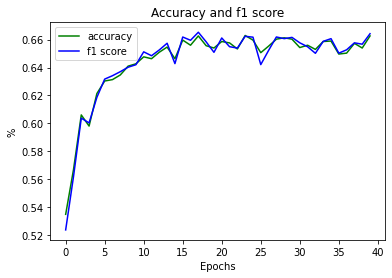

In [9]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# loss_train = history.history['accuracy']
# loss_val = history.history['f1 score']
epochs = range(0,40)
plt.plot(epochs, accuracyGlobal, 'g', label='accuracy')
plt.plot(epochs, f1ScoreGlobal, 'b', label='f1 score')
plt.title('Accuracy and f1 score')
plt.xlabel('Epochs')
plt.ylabel('%')
plt.legend()
plt.show()